In [1]:
from dotenv import load_dotenv
load_dotenv()

True

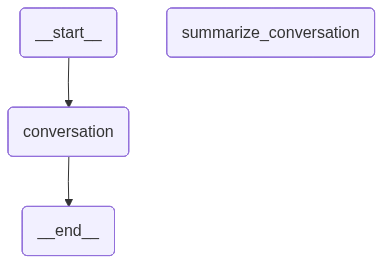

In [2]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

STREAMING FULL STATE


In [3]:
config = {"configurable": {"thread_id": "42"}}

# Start a short interactive chat
user_message = HumanMessage(content="Hey there! I'm Sarthak, how are you?")
for update in graph.stream(
    {"messages": [user_message]},
    config,
    stream_mode="updates"
):
    # Each chunk is an update (partial response)
    print(update)



{'conversation': {'messages': AIMessage(content="Hello Sarthak! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 19, 'total_tokens': 52, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CVHiyzPCcRxwt3ELpUkEErMCI6EJu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--7428d062-254a-4315-a487-8d39ea688375-0', usage_metadata={'input_tokens': 19, 'output_tokens': 33, 'total_tokens': 52, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [4]:
for chunk in graph.stream({"messages": [HumanMessage(content="Hey there! I'm Sarthak, how are you?")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello Sarthak! I'm here and ready to help you with whatever you need. How can I assist you today?


STREAMING VALUES

In [5]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="Hey there! I'm Sarthak, how are you?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

Hey there! I'm Sarthak, how are you?
---------------------------------------------------------------------------
================================ Human Message =================================

Hey there! I'm Sarthak, how are you?
================================== Ai Message ==================================

Hello Sarthak! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?
---------------------------------------------------------------------------


STREAMING TOKENS

In [6]:

config = {"configurable": {"thread_id": "7"}}

input_message = HumanMessage(content="Give me a quick summary of the Golden State Warriors.")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    node = event["metadata"].get("langgraph_node", "unknown")
    event_type = event["event"]
    name = event["name"]
    print(f"[Node: {node}] Event Type: {event_type} | Name: {name}")

[Node: unknown] Event Type: on_chain_start | Name: LangGraph
[Node: conversation] Event Type: on_chain_start | Name: conversation
[Node: conversation] Event Type: on_chat_model_start | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOpenAI
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatOp

using event['metadata']['langgraph_node'] to select the node to stream from and event['data'] to get the actual data for each event, which in this case is an AIMessageChunk.

In [7]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Give me a quick summary of the Golden State Warriors.")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--5cb0edd2-1ec7-45c3-8598-d57274792a1d')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--5cb0edd2-1ec7-45c3-8598-d57274792a1d')}
{'chunk': AIMessageChunk(content=' Golden', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--5cb0edd2-1ec7-45c3-8598-d57274792a1d')}
{'chunk': AIMessageChunk(content=' State', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--5cb0edd2-1ec7-45c3-8598-d57274792a1d')}
{'chunk': AIMessageChunk(content=' Warriors', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--5cb0edd2-1ec7-45c3-8598-d57274792a1d')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--5cb0edd2-1ec7-45c3-8598-d57274792a1d')}
{'chunk': AIMessa

using the chunk key to get AIMessage chunk

In [8]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Give me a quick summary of the Golden State Warriors.")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| Golden| State| Warriors| are| a| professional| basketball| team| based| in| San| Francisco|,| California|.| They| are| a| member| of| the| Western| Conference| in| the| National| Basketball| Association| (|NBA|).| The| team| was| founded| in| |194|6| as| the| Philadelphia| Warriors|,| and| they| moved| to| California| in| |196|2|,| initially| settling| in| San| Francisco| before| relocating| to| Oakland| in| |197|1|.| In| |201|9|,| they| returned| to| San| Francisco|,| playing| their| home| games| at| the| Chase| Center|.

|The| Warriors| have| a| rich| history|,| with| multiple| NBA| championships| to| their| name|.| They| experienced| significant| success| in| the| |201|0|s|,| winning| titles| in| |201|5|,| |201|7|,| and| |201|8|,| largely| due| to| the| contributions| of| star| players| like| Stephen| Curry|,| K|lay| Thompson|,| and| Dr|ay|mond| Green|,| under| the| leadership| of| head| coach| Steve| Kerr|.| The| team| is| known| for| its| fast|-paced|,| three|-point| shootin